In [1]:
from __future__ import print_function
#import os
import gc
import sys
import numpy as np
import numpy.random as rand
import math
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import stats
import keras as keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
#import pickle as pickle
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
import time
import glob
import numpy.ma as ma
from keras import backend as K
K.set_session(sess)

from cwola_utils_copy import AddPredictionsToScatter_nestedcrossval
from cwola_utils_copy import model_ensemble
from cwola_utils_copy import check_eff
from cwola_utils_copy import print_scatter_checkpoint
from cwola_utils_copy import get_p_value

rand.seed(0)
#sys.stdout = os.fdopen(sys.stdout.fileno(), 'w', 0)

from tensorflow.python.client import device_lib
print("Devices: ", device_lib.list_local_devices())

def getopts(argv):
    opts = {}  # Empty dictionary to store key-value pairs.
    while argv:  # While there are arguments left to parse...
        if argv[0][0] == '-':  # Found a "-name value" pair.
            opts[argv[0]] = argv[1]  # Add key and value to the dictionary.
        argv = argv[1:]  # Reduce the argument list by copying it starting from index 1.
    return opts

myargs = getopts(sys.argv)
print("Command line arguments: ", myargs)
if '-o' not in myargs:
    print("Setting default output name '-o': '~/model'")
    myargs['-o'] = "model"
if '-in' not in myargs:
    print("Setting default input directory to '/data1/users/jcollins/'")
    myargs['-in'] = '../data/'
if '-bin' not in myargs:
    myargs['-bin'] = 7
    print("Setting default bin '-bin':", myargs['-bin'])
else:
    myargs['-bin'] = int(myargs['-bin'])
if '-it' not in myargs:
    myargs['-it'] = 3
    print("Setting default  '-it':", myargs['-it'])
else:
    myargs['-it'] = int(myargs['-it'])
    
if '-kfold' not in myargs:
    myargs['-kfold'] = 4
    print("Setting default  '-kfold':",myargs['-kfold'])
else:
    myargs['-kfold'] = int(myargs['-kfold'])
    
if '-signal' not in myargs:
    myargs['-signal'] = 1
    print("Setting default  '-signal':",myargs['-signal'])
else:
    myargs['-signal'] = int(myargs['-signal'])
    
if '-sigevnts' not in myargs:
    myargs['-sigevnts'] = 2125
    print("Setting default  '-sigevnts':",myargs['-sigevnts'])
else:
    myargs['-sigevnts'] = int(myargs['-sigevnts'])
if '-bgevnts' not in myargs:
    myargs['-bgevnts'] = 553388
    print("Setting default  '-bgevnts':", myargs['-bgevnts'])
else:
    myargs['-bgevnts'] = int(myargs['-bgevnts'])
if '-bgoffset' not in myargs:
    myargs['-bgoffset'] = 0
    print("Setting default  '-bgoffset':", myargs['-bgoffset'])
else:
    myargs['-bgoffset'] = int(myargs['-bgoffset'])

if '-batchsize' not in myargs:
    myargs['-batchsize'] = 5000
    print("Setting default  '-batchsize':", myargs['-batchsize'])
else:
    myargs['-batchsize'] = int(myargs['-batchsize'])
if '-patience' not in myargs:
    myargs['-patience'] = 1000
    print("Setting default  '-patience':", myargs['-patience'])
else:
    myargs['-patience'] = int(myargs['-patience'])
if '-checkeff' not in myargs:
    myargs['-checkeff'] = 0.01
    print("Setting default  '-checkeff':", myargs['-checkeff'])
else:
    myargs['-checkeff'] = float(myargs['-checkeff'])

if '-loadonly' not in myargs:
    myargs['-loadonly'] = 0
    print("Setting default  '-loadonly':", myargs['-loadonly'])
else:
    myargs['-loadonly'] = float(myargs['-loadonly'])
if '-trainonly' not in myargs:
    myargs['-trainonly'] = 0
    print("Setting default  '-trainonly':", myargs['-trainonly'])
else:
    myargs['-trainonly'] = int(myargs['-trainonly'])

    
if '-startk' not in myargs:
    myargs['-startk'] = 0
    print("Setting default  '-startk':", myargs['-startk'])
else:
    myargs['-startk'] = int(myargs['-startk'])
if '-startl' not in myargs:
    myargs['-startl'] = 0
    print("Setting default  '-startl':", myargs['-startl'])
else:
    myargs['-startl'] = int(myargs['-startl'])
if '-endk' not in myargs:
    myargs['-endk'] = 0
    print("Setting default  '-endk':", myargs['-endk'])
else:
    myargs['-endk'] = int(myargs['-endk'])
if '-endl' not in myargs:
    myargs['-endl'] = 0
    print("Setting default  '-endl':", myargs['-endl'])
else:
    myargs['-endl'] = int(myargs['-endl'])
    
bin_i = myargs['-bin']    
data_prefix = myargs['-in']
output_prefix = myargs['-o']

#Which auxilliary variables to use
selected_vars = np.arange(1,60)
#Also use mJJ.
selected_vars_plus = np.append([0],selected_vars)

#Which 2d planes to make scatter plots in
axes_list = [[0,1]]
axes_labels = [['mJA','mJB']]

#Data binning in mJJ
mjjmin = 2001
mjjmax = 4350
mybinboundaries = np.round(np.logspace(np.log10(mjjmin), np.log10(mjjmax), num=16))
mybincenters = np.array([0.5*(mybinboundaries[i+1] + mybinboundaries[i]) for i in range(0,len(mybinboundaries)-1)])
mybinwidths = np.array([mybinboundaries[i+1] - mybinboundaries[i] for i in range(0,len(mybinboundaries)-1)])
mybincenterandwidth = np.vstack((mybincenters,mybinwidths)).T

def bin_data(data, binboundaries = mybinboundaries):
    databinned = []
    for i in range(0,len(binboundaries)-1):
        databinned.append(
            np.array([np.delete(myrow,0) for myrow in data if (myrow[0] < binboundaries[i+1] and myrow[0] >= binboundaries[i])])
        )
    return databinned

#Load bg data
print('\n')
numfiles = int((myargs['-bgoffset'] + myargs['-bgevnts'])/100000) + 1
print("Loading ", myargs['-in'] + 'bg_dataset_0.dat')
bgdata = np.loadtxt(myargs['-in'] + 'bg_dataset_0.dat')
for i in range(1,numfiles):
    filename = myargs['-in'] + 'bg_dataset_' + str(i) + '.dat'
    print("Loading ", filename)
    bgdata = np.append(bgdata,np.loadtxt(filename),axis=0)
bgdata = bgdata[myargs['-bgoffset']:myargs['-bgoffset']+myargs['-bgevnts']]
bgdata = bgdata[bgdata[:,0]>=mjjmin]
rand.shuffle(bgdata)

#Load signal data
if myargs['-signal']:
    print('Adding signal data')
    signaldata = np.loadtxt(myargs['-in'] + 'W_WW_3000_400.dat')[:myargs['-sigevnts']]
    signaldata = signaldata[signaldata[:,0]>=mjjmin]
    bg_plus_signal = np.nan_to_num(np.append(signaldata,bgdata,axis=0))
    rand.shuffle(bg_plus_signal)
    
    bghist = np.histogram(bgdata[:,0],bins=mybinboundaries)[0]
    sighist = np.histogram(signaldata[:,0],bins=mybinboundaries)[0]

    B = bghist[bin_i-1] + bghist[bin_i] + bghist[bin_i+1]
    S = sighist[bin_i-1] + sighist[bin_i] + sighist[bin_i+1]
    print("\nIn Signal Region:")
    print("S = ", S)
    print("B = ", B)
    print("S/B =", '%.4f' % (float(S)/float(B)))
    print("S/sqrt(B)", '%.4f' % (float(S)/np.sqrt(float(B))))
    print("\n")
    del signaldata
    del bgdata
else:
    print('Not adding signal data')
    bg_plus_signal = np.nan_to_num(bgdata)
    del bgdata
sys.stdout.flush()




# Preprocessor for data before feeding it to NN
#   1) Take log of jet mass variables
#   2) Standard scale all auxilliary variables
def myprepreprocessor(predata, massvars=None):
    if massvars is None:
        massvars = [0,1]
    newdata = np.copy(predata)
    newdata[:,massvars] = np.nan_to_num(np.log10(newdata[:,massvars]+40))
    return newdata


bg_plus_signal=bg_plus_signal[:,selected_vars_plus]
myscaler = preprocessing.StandardScaler().fit(myprepreprocessor(bg_plus_signal,massvars=[1,2])[:,1:])
def preprocess(data):
    return np.clip(myscaler.transform(myprepreprocessor(data,massvars=[0,1])),-3,3)
rand.shuffle(bg_plus_signal)

bg_plus_signal_binned = bin_data(bg_plus_signal)
del bg_plus_signal

import warnings
warnings.filterwarnings('ignore')

ntries = myargs['-it']
times = list()
print("Working on bin ", bin_i)

batch_size = myargs['-batchsize']

    

/home/Jack/.virtualenvs/Keras/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


Devices:  [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18164007588399995585
]
Command line arguments:  {'-f': '/home/Jack/.local/share/jupyter/runtime/kernel-691df24d-2bf4-4c80-9ad3-ab53e143d45c.json'}
Setting default output name '-o': '~/model'
Setting default input directory to '/data1/users/jcollins/'
Setting default bin '-bin': 7
Setting default  '-it': 3
Setting default  '-kfold': 4
Setting default  '-signal': 1
Setting default  '-sigevnts': 2125
Setting default  '-bgevnts': 553388
Setting default  '-bgoffset': 0
Setting default  '-batchsize': 5000
Setting default  '-patience': 1000
Setting default  '-checkeff': 0.01
Setting default  '-loadonly': 0
Setting default  '-trainonly': 0
Setting default  '-startk': 0
Setting default  '-startl': 0
Setting default  '-endk': 0
Setting default  '-endl': 0


Loading  ../data/bg_dataset_0.dat
Loading  ../data/bg_dataset_1.dat
Loading  ../data/bg_dataset_2.dat
Loading  ../data/bg_dataset_3.dat
Load

In [4]:
output_prefix = 'CWoLa-Hunting-decorrelation-toy'

kfolds = 4
checkeff = 0.005
patience = 1000
ntries = 1
bin_i=7
axes_list=[[0,1],[5,32]]
axes_labels=[['pT1','pT2'],["mJ1","mJ2"]]
numvars=59
batch_size=2000

rates = np.array([0.5,0.95,0.99,0.998]),
colors=['silver','grey','khaki','goldenrod','firebrick']

 k = 0 l = 1
Now training model  1  of  1


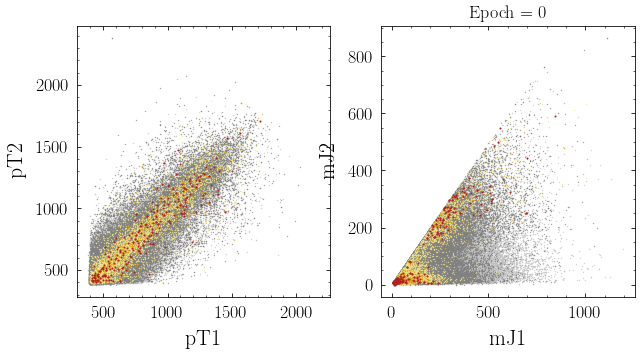

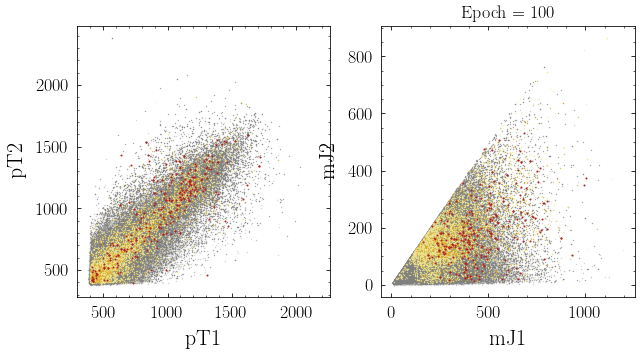

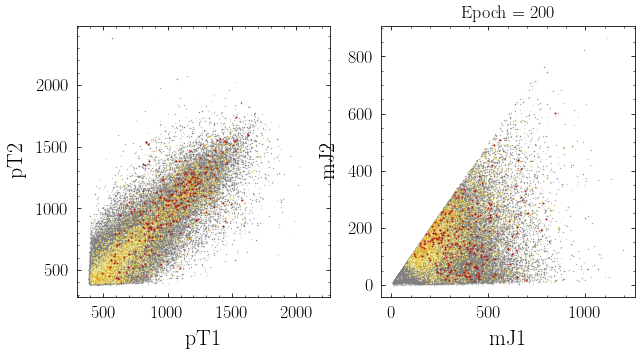

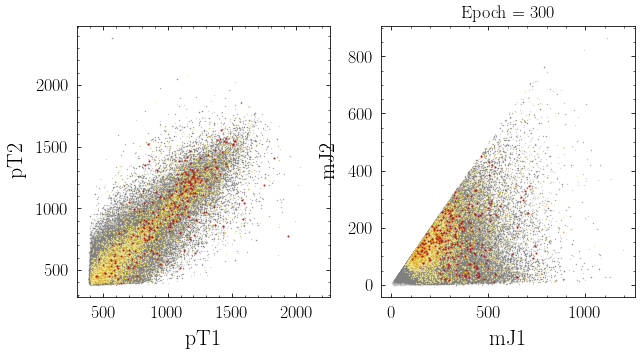

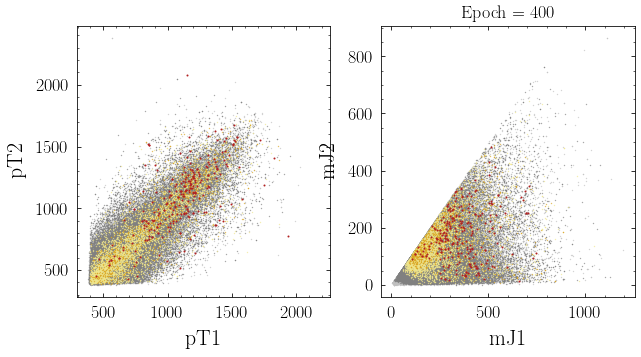

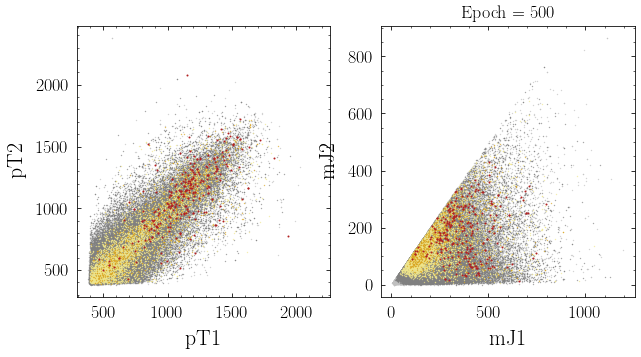

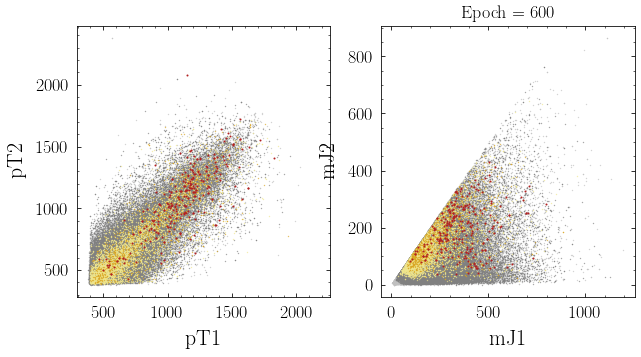

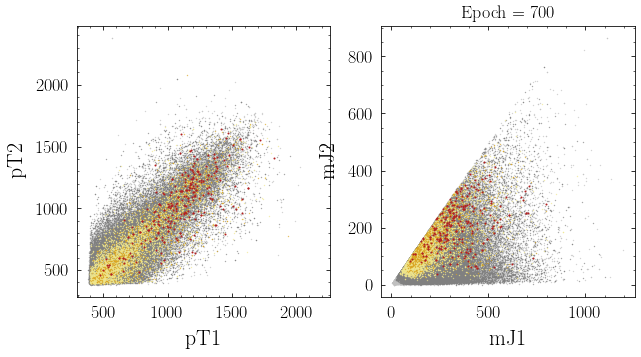

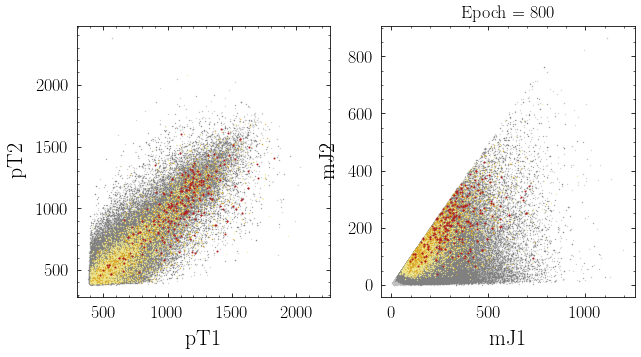

In [ ]:
times = list()


model_utils = model_ensemble(bg_plus_signal_binned, bin_i = bin_i, kfolds=kfolds, eff_for_thresh = checkeff)

i=0
k=0
l=1

print(" k =", k, "l =", l)
#Naming convention for model files.
checkpoint_name = output_prefix + "_" + str(bin_i) + "_[" + str(k) + "," + str(l) + "]_" + str(i)
start = time.time()

data_train, data_valid, labels_train, labels_valid, weights_train, weights_valid = model_utils.get_trainval_data(k,l)

print("Now training model ", i + 1, " of ", ntries)

K.clear_session()
#Following hyperparams seem to work well. Not done systematic optimization. Maybe something else works much better.
myoptimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.8, beta_2=0.99, epsilon=1e-08, decay=0.0005)

#Custom callback to record tpr at fixed fpr (set by eff_rate), where tpr and fpr refer to signal and sideband regions rather than truth-labels.
my_check_eff = check_eff(verbose=0, filename = checkpoint_name + '_best.h5', patience = patience,
                         min_epoch=50, batch_size=batch_size,
                         plot_period=50,eff_rate = checkeff,
                         plotmode="print",avg_length=20)

#Custom callback for printing scatter plots every few epochs. Useful for troubleshooting, but slows down training considerably.
my_print = print_scatter_checkpoint(filename = checkpoint_name,
                                    axes_list = axes_list,
                                    axes_labels = axes_labels,
                                    period=100,
                                    training_data=np.append(data_train,data_valid,axis=0),
                                    training_labels=np.append(labels_train,labels_valid,axis=0),
                                    preprocess=preprocess,
                                    rates=rates,
                                    colors=colors,
                                    mode = "show")

mycallbacks=[my_print,
    my_check_eff]

#Following seems to work well for benchmarks. Not systematically optimized. I basically just played around until something worked.
#However, bias initialization seems very important. Keras relu by default initializes to 0 bias, and especially in the first layer will not move from that initialization during training. This is very suboptimal.
model = Sequential()
model.add(Dense(64, input_dim=numvars,use_bias=True,
                bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.5)))
model.add(keras.layers.LeakyReLU(alpha=0.01))
#model.add(Dropout(0.1))
model.add(Dense(64, use_bias=True, activation='elu',
                bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
#model.add(Dropout(0.1))
model.add(Dense(32, use_bias=True, activation='elu',
                bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
#model.add(Dropout(0.1))
model.add(Dense(16, use_bias=True, activation='elu',
                bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
model.add(Dense(8, use_bias=True, activation='elu',
                bias_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.2)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=myoptimizer,
              loss='binary_crossentropy')

model_hist = model.fit(data_train, labels_train, epochs=2000, batch_size=batch_size,
                       validation_data=(data_valid, labels_valid, weights_valid),
                       callbacks=mycallbacks,verbose=0,
                       sample_weight = weights_train)

del model
K.clear_session()           #Otherwise TensorFlow eats up all GPU memory with previous models.


model = keras.models.load_model(checkpoint_name + "_best.h5")
model_utils.add_model(model, None, k, l,checkpoint_name + "_best.h5")
plt.close('all')

print("Selected Model:")
model_utils.print_scatter_onemodel_signalplussidebandregion(k,l,i,axes_list=axes_list,axes_labels=axes_labels,
                                                            rates=rates,
                                                            colors=colors)

for i in range(5):
    gc.collect()
end = time.time()

times.append(end-start)
print("Elapsed Time = ", times[-1])